Question 1: What are the factors or variables that more likely leads to injury in a collision? Is it possible to predict if the collision involves injury using the information of the collision and the weather at the date and time the collision occur?

In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('../env')
load_dotenv(dotenv_path=env_path)

pd.set_option('display.max_columns', None)

DB_TORONTO_TRAFFIC_COLLISIONS_ALL = os.getenv('DB_TORONTO_TRAFFIC_COLLISIONS_ALL')

engine = create_engine(DB_TORONTO_TRAFFIC_COLLISIONS_ALL)

In [2]:
query_1_all_collision= "SELECT * FROM collisions"
gdf_all_collision = gpd.read_postgis(query_1_all_collision, engine, geom_col="geometry")

Add year, month and day for timestamp.

In [3]:
from datetime import datetime

gdf_all_collision["utc_year"] = gdf_all_collision["OCC_DATE"].apply(lambda x: datetime.fromtimestamp(x / 1000).year)
gdf_all_collision["utc_month"] = gdf_all_collision["OCC_DATE"].apply(lambda x: datetime.fromtimestamp(x / 1000).month)
gdf_all_collision["utc_day"] = gdf_all_collision["OCC_DATE"].apply(lambda x: datetime.fromtimestamp(x / 1000).day)
gdf_all_collision

,_id,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COLLISIONS,FTR_COLLISIONS,PD_COLLISIONS,HOOD_158,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,has_valid_location,OCC_DOM,geometry,utc_year,utc_month,utc_day
0,1,1388552400000,January,Wednesday,2014,2,D23,0,0,0,1,007,Willowridge-Martingrove-Richview (7),-79.563139,43.674411,1,0,0,0,0,1,1,MULTIPOINT (-79.56314 43.67441),2014,1,1
1,2,1388552400000,January,Wednesday,2014,14,D32,0,0,0,1,105,Lawrence Park North (105),-79.397589,43.726091,1,0,0,0,0,1,1,MULTIPOINT (-79.39759 43.72609),2014,1,1
2,3,1388552400000,January,Wednesday,2014,2,None,0,1,0,0,None,None,NaN,NaN,1,0,0,0,0,0,1,MULTIPOINT (0 0),2014,1,1
3,4,1388552400000,January,Wednesday,2014,3,None,0,0,0,1,None,None,NaN,NaN,1,0,0,0,0,0,1,MULTIPOINT (0 0),2014,1,1
4,5,1388552400000,January,Wednesday,2014,5,None,0,1,0,0,None,None,NaN,NaN,1,0,0,0,0,0,1,MULTIPOINT (0 0),2014,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716486,722917,1735621200000,December,Tuesday,2024,18,D42,0,1,0,0,None,None,NaN,NaN,1,0,0,0,0,0,31,MULTIPOINT (0 0),2024,12,31
716487,722918,1735621200000,December,Tuesday,2024,18,D41,0,0,0,1,126,Dorset Park (126),-79.281097,43.765821,1,0,0,0,0,1,31,MULTIPOINT (-79.2811 43.76582),2024,12,31
716488,722919,1735621200000,December,Tuesday,2024,18,D43,0,0,0,1,138,Eglinton East (138),-79.247407,43.735223,1,0,1,0,0,1,31,MULTIPOINT (-79.24741 43.73522),2024,12,31
716489,722920,1735621200000,December,Tuesday,2024,15,D14,0,0,0,1,079,University (79),-79.400175,43.657972,1,0,0,0,0,1,31,MULTIPOINT (-79.40018 43.65797),2024,12,31


First, look for correlations between whether the case involve an injury and all other attributes of the collision dataset.

In [4]:
corr_matrix = gdf_all_collision.corr()
corr_matrix["INJURY_COLLISIONS"].sort_values(ascending=False)

INJURY_COLLISIONS     1.000000
PASSENGER             0.397932
PEDESTRIAN            0.320276
BICYCLE               0.227934
MOTORCYCLE            0.049568
has_valid_location    0.041617
OCC_HOUR              0.029236
LAT_WGS84             0.020836
utc_month             0.017848
LONG_WGS84            0.006669
utc_day               0.000930
OCC_DOM               0.000930
FATALITIES           -0.011144
OCC_DATE             -0.021108
_id                  -0.022821
utc_year             -0.022859
OCC_YEAR             -0.022859
AUTOMOBILE           -0.029583
FTR_COLLISIONS       -0.138152
PD_COLLISIONS        -0.633582
Name: INJURY_COLLISIONS, dtype: float64

We would like to get the correlation between whether the case involve an injury and all other attributes of the dataset, excluding records without a valid collision location.

In [5]:
gdf_all_collision_valid = gdf_all_collision[gdf_all_collision["has_valid_location"] == 1]
corr_matrix_valid_location = gdf_all_collision_valid.corr()
corr_matrix_valid_location["INJURY_COLLISIONS"].sort_values(ascending=False)

INJURY_COLLISIONS     1.000000
PASSENGER             0.402142
PEDESTRIAN            0.331302
BICYCLE               0.234434
MOTORCYCLE            0.051417
OCC_HOUR              0.028652
LAT_WGS84             0.020836
utc_month             0.018130
LONG_WGS84            0.006669
OCC_DOM               0.000902
utc_day               0.000902
FATALITIES           -0.012208
OCC_DATE             -0.020769
_id                  -0.022096
OCC_YEAR             -0.022525
utc_year             -0.022525
AUTOMOBILE           -0.030125
FTR_COLLISIONS       -0.143942
PD_COLLISIONS        -0.634368
has_valid_location         NaN
Name: INJURY_COLLISIONS, dtype: float64

We would like to extract the daily weather data from postgre and perform data engineering on weather data.

In [6]:
query_2_all_collision = "SELECT * FROM daily_weather"
df_weather = pd.read_sql(query_2_all_collision, engine)
df_weather

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime
0,0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,None,-10.0,None,-15.3,None,-12.7,None,30.7,None,0.0,None,0.0,None,0.0,None,0.0,None,3.0,None,27.0,None,35,None,1388552400000
1,1,-79.63,43.68,TORONTO INTL A,6158731,2014-01-02,2014,1,2,None,-15.2,None,-20.0,None,-17.6,None,35.6,None,0.0,None,0.0,None,1.0,None,0.8,None,3.0,None,35.0,None,48,None,1388638800000
2,2,-79.63,43.68,TORONTO INTL A,6158731,2014-01-03,2014,1,3,None,-9.2,None,-23.8,None,-16.5,None,34.5,None,0.0,None,0.0,None,0.0,None,0.0,None,4.0,None,21.0,None,41,None,1388725200000
3,3,-79.63,43.68,TORONTO INTL A,6158731,2014-01-04,2014,1,4,None,-0.4,None,-9.2,None,-4.8,None,22.8,None,0.0,None,0.0,None,0.4,None,0.4,None,4.0,None,23.0,None,57,None,1388811600000
4,4,-79.63,43.68,TORONTO INTL A,6158731,2014-01-05,2014,1,5,None,-0.1,None,-2.6,None,-1.4,None,19.4,None,0.0,None,1.8,None,11.6,None,14.4,None,6.0,None,NaN,None,<31,None,1388898000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,4013,-79.63,43.68,TORONTO INTL A,6158731,2024-12-27,2024,12,27,None,2.2,None,0.0,None,1.1,None,16.9,None,0.0,None,0.0,T,0.0,None,0.0,T,4.0,None,7.0,None,36.0,None,1735275600000
4014,4014,-79.63,43.68,TORONTO INTL A,6158731,2024-12-28,2024,12,28,None,9.7,None,1.3,None,5.5,None,12.5,None,0.0,None,0.8,None,0.0,None,0.8,None,0.0,T,NaN,M,None,M,1735362000000
4015,4015,-79.63,43.68,TORONTO INTL A,6158731,2024-12-29,2024,12,29,None,10.3,None,2.2,None,6.3,None,11.7,None,0.0,None,25.1,None,0.0,None,25.1,None,NaN,None,19.0,None,48.0,None,1735448400000
4016,4016,-79.63,43.68,TORONTO INTL A,6158731,2024-12-30,2024,12,30,None,9.5,None,2.0,None,5.8,None,12.2,None,0.0,None,1.2,None,0.0,None,1.2,None,NaN,None,18.0,None,67.0,None,1735534800000


In [7]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      4018 non-null   int64  
 1   Longitude (x)              4018 non-null   float64
 2   Latitude (y)               4018 non-null   float64
 3   Station Name               4018 non-null   object 
 4   Climate ID                 4018 non-null   int64  
 5   Date/Time                  4018 non-null   object 
 6   Year                       4018 non-null   int64  
 7   Month                      4018 non-null   int64  
 8   Day                        4018 non-null   int64  
 9   Data Quality               0 non-null      object 
 10  Max Temp (°C)              3998 non-null   float64
 11  Max Temp Flag              24 non-null     object 
 12  Min Temp (°C)              3997 non-null   float64
 13  Min Temp Flag              25 non-null     objec

First, we would like to convert the time from utc to ltc for weather data.

In [8]:
'''
from datetime import datetime
import pytz

def ltc_to_utc_ms(unix_ms):
    # Create datetime object in Toronto time
    toronto_tz = pytz.timezone('America/Toronto')
    local_dt = datetime.fromtimestamp(unix_ms / 1000).replace(tzinfo=toronto_tz)
    
    # Convert to UTC
    utc_dt = local_dt.astimezone(pytz.UTC)
    
    # Convert back to Unix timestamp in milliseconds
    utc_ts_ms = int(utc_dt.timestamp() * 1000)
    return utc_ts_ms

# Apply to dataframe
df_weather["Datetime_utc"] = df_weather["Datetime"].apply(ltc_to_utc_ms)

# To verify:
test_row = df_weather.iloc[0]
local = datetime.fromtimestamp(test_row['Datetime'] / 1000)
utc = datetime.fromtimestamp(test_row['Datetime_utc'] / 1000, tz=pytz.UTC)
print(f"Local: {local}")
print(f"UTC: {utc}")
'''

'\nfrom datetime import datetime\nimport pytz\n\ndef ltc_to_utc_ms(unix_ms):\n    # Create datetime object in Toronto time\n    toronto_tz = pytz.timezone(\'America/Toronto\')\n    local_dt = datetime.fromtimestamp(unix_ms / 1000).replace(tzinfo=toronto_tz)\n    \n    # Convert to UTC\n    utc_dt = local_dt.astimezone(pytz.UTC)\n    \n    # Convert back to Unix timestamp in milliseconds\n    utc_ts_ms = int(utc_dt.timestamp() * 1000)\n    return utc_ts_ms\n\n# Apply to dataframe\ndf_weather["Datetime_utc"] = df_weather["Datetime"].apply(ltc_to_utc_ms)\n\n# To verify:\ntest_row = df_weather.iloc[0]\nlocal = datetime.fromtimestamp(test_row[\'Datetime\'] / 1000)\nutc = datetime.fromtimestamp(test_row[\'Datetime_utc\'] / 1000, tz=pytz.UTC)\nprint(f"Local: {local}")\nprint(f"UTC: {utc}")\n'

We would like to conduct data cleaning on the daily weather dataset.
We would like to investiagate the the n/a in max temp, min temp, mean temp, total rain, total snow, total precip, snow on grnd.

In [9]:
# max temp
max_temp_na_columns = df_weather[df_weather["Max Temp (°C)"].isna()]

In [10]:
df_weather["Max Temp Interpolated"] = df_weather["Max Temp (°C)"].interpolate(limit=3)
df_weather[df_weather["Max Temp (°C)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated
1407,1407,-79.63,43.68,TORONTO INTL A,6158731,2017-11-08,2017,11,8,None,NaN,M,-1.2,E,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,22.0,None,37,None,1510117200000,8.050000
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.600000
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.650000
2604,2604,-79.63,43.68,TORONTO INTL A,6158731,2021-02-17,2021,2,17,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,12.0,None,NaN,M,None,M,1613538000000,-5.500000
2605,2605,-79.63,43.68,TORONTO INTL A,6158731,2021-02-18,2021,2,18,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,10.0,E,NaN,None,None,M,1613624400000,-4.000000
2757,2757,-79.63,43.68,TORONTO INTL A,6158731,2021-07-20,2021,7,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,56.0,None,1626753600000,27.000000
2769,2769,-79.63,43.68,TORONTO INTL A,6158731,2021-08-01,2021,8,1,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,38.0,None,1627790400000,23.200000
2899,2899,-79.63,43.68,TORONTO INTL A,6158731,2021-12-09,2021,12,9,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,1.8,None,1.8,None,2.0,None,13.0,None,37.0,None,1639026000000,2.300000
2909,2909,-79.63,43.68,TORONTO INTL A,6158731,2021-12-19,2021,12,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,8.0,None,36.0,None,32.0,None,1639890000000,1.333333
2910,2910,-79.63,43.68,TORONTO INTL A,6158731,2021-12-20,2021,12,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,4.0,None,22.0,None,46.0,None,1639976400000,2.366667


In [11]:
# min temp
min_temp_na_columns = df_weather[df_weather["Min Temp (°C)"].isna()]
df_weather[df_weather["Min Temp (°C)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated
1712,1712,-79.63,43.68,TORONTO INTL A,6158731,2018-09-09,2018,9,9,None,16.0,E,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1536465600000,16.000000
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.600000
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.650000
2604,2604,-79.63,43.68,TORONTO INTL A,6158731,2021-02-17,2021,2,17,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,12.0,None,NaN,M,None,M,1613538000000,-5.500000
2605,2605,-79.63,43.68,TORONTO INTL A,6158731,2021-02-18,2021,2,18,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,10.0,E,NaN,None,None,M,1613624400000,-4.000000
2757,2757,-79.63,43.68,TORONTO INTL A,6158731,2021-07-20,2021,7,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,56.0,None,1626753600000,27.000000
2769,2769,-79.63,43.68,TORONTO INTL A,6158731,2021-08-01,2021,8,1,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,38.0,None,1627790400000,23.200000
2899,2899,-79.63,43.68,TORONTO INTL A,6158731,2021-12-09,2021,12,9,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,1.8,None,1.8,None,2.0,None,13.0,None,37.0,None,1639026000000,2.300000
2909,2909,-79.63,43.68,TORONTO INTL A,6158731,2021-12-19,2021,12,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,8.0,None,36.0,None,32.0,None,1639890000000,1.333333
2910,2910,-79.63,43.68,TORONTO INTL A,6158731,2021-12-20,2021,12,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,4.0,None,22.0,None,46.0,None,1639976400000,2.366667


In [12]:
df_weather["Min Temp Interpolated"] = df_weather["Min Temp (°C)"].interpolate(limit=3)
df_weather[df_weather["Min Temp (°C)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated
1712,1712,-79.63,43.68,TORONTO INTL A,6158731,2018-09-09,2018,9,9,None,16.0,E,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1536465600000,16.000000,12.150000
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.600000,5.450000
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.650000,-6.150000
2604,2604,-79.63,43.68,TORONTO INTL A,6158731,2021-02-17,2021,2,17,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,12.0,None,NaN,M,None,M,1613538000000,-5.500000,-12.600000
2605,2605,-79.63,43.68,TORONTO INTL A,6158731,2021-02-18,2021,2,18,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,10.0,E,NaN,None,None,M,1613624400000,-4.000000,-9.900000
2757,2757,-79.63,43.68,TORONTO INTL A,6158731,2021-07-20,2021,7,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,56.0,None,1626753600000,27.000000,17.000000
2769,2769,-79.63,43.68,TORONTO INTL A,6158731,2021-08-01,2021,8,1,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,38.0,None,1627790400000,23.200000,12.050000
2899,2899,-79.63,43.68,TORONTO INTL A,6158731,2021-12-09,2021,12,9,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,1.8,None,1.8,None,2.0,None,13.0,None,37.0,None,1639026000000,2.300000,-2.900000
2909,2909,-79.63,43.68,TORONTO INTL A,6158731,2021-12-19,2021,12,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,8.0,None,36.0,None,32.0,None,1639890000000,1.333333,-2.666667
2910,2910,-79.63,43.68,TORONTO INTL A,6158731,2021-12-20,2021,12,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,4.0,None,22.0,None,46.0,None,1639976400000,2.366667,-1.933333


In [13]:
# mean temp
mean_temp_na_columns = df_weather[df_weather["Mean Temp (°C)"].isna()]
df_weather[df_weather["Mean Temp (°C)"].isna()].head(n = 5)

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated
1407,1407,-79.63,43.68,TORONTO INTL A,6158731,2017-11-08,2017,11,8,None,NaN,M,-1.2,E,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,22.0,None,37,None,1510117200000,8.05,-1.20
1564,1564,-79.63,43.68,TORONTO INTL A,6158731,2018-04-14,2018,4,14,None,3.8,None,-4.4,None,NaN,M,NaN,M,NaN,M,5.6,None,4.2,None,35.8,None,1.0,None,5.0,None,52,None,1523678400000,3.80,-4.40
1712,1712,-79.63,43.68,TORONTO INTL A,6158731,2018-09-09,2018,9,9,None,16.0,E,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1536465600000,16.00,12.15
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.60,5.45
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.65,-6.15


In [14]:
df_weather["Mean Temp Interpolated"] = df_weather["Mean Temp (°C)"].interpolate(limit=3)
df_weather[df_weather["Mean Temp (°C)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated
1407,1407,-79.63,43.68,TORONTO INTL A,6158731,2017-11-08,2017,11,8,None,NaN,M,-1.2,E,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,22.0,None,37,None,1510117200000,8.050000,-1.200000,2.85
1564,1564,-79.63,43.68,TORONTO INTL A,6158731,2018-04-14,2018,4,14,None,3.8,None,-4.4,None,NaN,M,NaN,M,NaN,M,5.6,None,4.2,None,35.8,None,1.0,None,5.0,None,52,None,1523678400000,3.800000,-4.400000,1.10
1712,1712,-79.63,43.68,TORONTO INTL A,6158731,2018-09-09,2018,9,9,None,16.0,E,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1536465600000,16.000000,12.150000,14.35
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.600000,5.450000,9.05
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.650000,-6.150000,-3.45
2604,2604,-79.63,43.68,TORONTO INTL A,6158731,2021-02-17,2021,2,17,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,12.0,None,NaN,M,None,M,1613538000000,-5.500000,-12.600000,-9.10
2605,2605,-79.63,43.68,TORONTO INTL A,6158731,2021-02-18,2021,2,18,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,10.0,E,NaN,None,None,M,1613624400000,-4.000000,-9.900000,-7.00
2757,2757,-79.63,43.68,TORONTO INTL A,6158731,2021-07-20,2021,7,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,56.0,None,1626753600000,27.000000,17.000000,22.05
2769,2769,-79.63,43.68,TORONTO INTL A,6158731,2021-08-01,2021,8,1,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,38.0,None,1627790400000,23.200000,12.050000,17.65
2899,2899,-79.63,43.68,TORONTO INTL A,6158731,2021-12-09,2021,12,9,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,1.8,None,1.8,None,2.0,None,13.0,None,37.0,None,1639026000000,2.300000,-2.900000,-0.30


In [15]:
# heat deg days
heat_deg_days_na_columns = df_weather[df_weather["Heat Deg Days (°C)"].isna()]
df_weather[df_weather["Heat Deg Days (°C)"].isna()].head(n = 5)

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated
1407,1407,-79.63,43.68,TORONTO INTL A,6158731,2017-11-08,2017,11,8,None,NaN,M,-1.2,E,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,22.0,None,37,None,1510117200000,8.05,-1.20,2.85
1564,1564,-79.63,43.68,TORONTO INTL A,6158731,2018-04-14,2018,4,14,None,3.8,None,-4.4,None,NaN,M,NaN,M,NaN,M,5.6,None,4.2,None,35.8,None,1.0,None,5.0,None,52,None,1523678400000,3.80,-4.40,1.10
1712,1712,-79.63,43.68,TORONTO INTL A,6158731,2018-09-09,2018,9,9,None,16.0,E,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1536465600000,16.00,12.15,14.35
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.60,5.45,9.05
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.65,-6.15,-3.45


In [16]:
df_weather["Mean Temp Interpolated"] = df_weather["Mean Temp (°C)"].interpolate(limit=3)
df_weather[df_weather["Mean Temp (°C)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated
1407,1407,-79.63,43.68,TORONTO INTL A,6158731,2017-11-08,2017,11,8,None,NaN,M,-1.2,E,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,22.0,None,37,None,1510117200000,8.050000,-1.200000,2.85
1564,1564,-79.63,43.68,TORONTO INTL A,6158731,2018-04-14,2018,4,14,None,3.8,None,-4.4,None,NaN,M,NaN,M,NaN,M,5.6,None,4.2,None,35.8,None,1.0,None,5.0,None,52,None,1523678400000,3.800000,-4.400000,1.10
1712,1712,-79.63,43.68,TORONTO INTL A,6158731,2018-09-09,2018,9,9,None,16.0,E,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1536465600000,16.000000,12.150000,14.35
1958,1958,-79.63,43.68,TORONTO INTL A,6158731,2019-05-13,2019,5,13,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,7.6,None,0.0,None,7.6,None,NaN,None,8.0,None,52.0,None,1557720000000,12.600000,5.450000,9.05
2575,2575,-79.63,43.68,TORONTO INTL A,6158731,2021-01-19,2021,1,19,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,0.6,None,0.6,None,0.0,T,26.0,None,58.0,None,1611032400000,-0.650000,-6.150000,-3.45
2604,2604,-79.63,43.68,TORONTO INTL A,6158731,2021-02-17,2021,2,17,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,12.0,None,NaN,M,None,M,1613538000000,-5.500000,-12.600000,-9.10
2605,2605,-79.63,43.68,TORONTO INTL A,6158731,2021-02-18,2021,2,18,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,10.0,E,NaN,None,None,M,1613624400000,-4.000000,-9.900000,-7.00
2757,2757,-79.63,43.68,TORONTO INTL A,6158731,2021-07-20,2021,7,20,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,56.0,None,1626753600000,27.000000,17.000000,22.05
2769,2769,-79.63,43.68,TORONTO INTL A,6158731,2021-08-01,2021,8,1,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,38.0,None,1627790400000,23.200000,12.050000,17.65
2899,2899,-79.63,43.68,TORONTO INTL A,6158731,2021-12-09,2021,12,9,None,NaN,M,NaN,M,NaN,M,NaN,M,NaN,M,0.0,None,1.8,None,1.8,None,2.0,None,13.0,None,37.0,None,1639026000000,2.300000,-2.900000,-0.30


In [17]:
# total rain
total_rain_na_columns = df_weather[df_weather["Total Rain (mm)"].isna()]
df_weather[df_weather["Total Rain (mm)"].isna()].head(n = 5)

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated
36,596,-79.63,43.68,TORONTO INTL A,6158731,2015-08-20,2015,8,20,None,26.0,None,16.5,None,21.3,None,0.0,None,3.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440043200000,26.0,16.5,21.3
376,375,-79.63,43.68,TORONTO INTL A,6158731,2015-01-11,2015,1,11,None,-0.2,None,-10.8,None,-5.5,None,23.5,None,0.0,None,NaN,M,0.4,None,NaN,M,2.0,None,24.0,None,43,None,1420952400000,-0.2,-10.8,-5.5
388,387,-79.63,43.68,TORONTO INTL A,6158731,2015-01-23,2015,1,23,None,1.4,None,-6.2,None,-2.4,None,20.4,None,0.0,None,NaN,M,NaN,M,NaN,M,0.0,None,NaN,None,<31,None,1421989200000,1.4,-6.2,-2.4
404,403,-79.63,43.68,TORONTO INTL A,6158731,2015-02-08,2015,2,8,None,-8.2,None,-13.2,None,-10.7,None,28.7,None,0.0,None,NaN,M,3.0,None,NaN,M,17.0,None,4.0,None,35,None,1423371600000,-8.2,-13.2,-10.7
454,453,-79.63,43.68,TORONTO INTL A,6158731,2015-03-30,2015,3,30,None,7.9,None,-2.7,None,2.6,None,15.4,None,0.0,None,NaN,M,0.0,T,NaN,M,NaN,None,29.0,None,67,None,1427688000000,7.9,-2.7,2.6


In [18]:
df_weather["Total Rain Interpolated"] = df_weather["Total Rain (mm)"].interpolate()
df_weather[df_weather["Total Rain (mm)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated
36,596,-79.63,43.68,TORONTO INTL A,6158731,2015-08-20,2015,8,20,None,26.0,None,16.5,None,21.3,None,0.0,None,3.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440043200000,26.0,16.50,21.30,0.000000
376,375,-79.63,43.68,TORONTO INTL A,6158731,2015-01-11,2015,1,11,None,-0.2,None,-10.8,None,-5.5,None,23.5,None,0.0,None,NaN,M,0.4,None,NaN,M,2.0,None,24.0,None,43,None,1420952400000,-0.2,-10.80,-5.50,0.000000
388,387,-79.63,43.68,TORONTO INTL A,6158731,2015-01-23,2015,1,23,None,1.4,None,-6.2,None,-2.4,None,20.4,None,0.0,None,NaN,M,NaN,M,NaN,M,0.0,None,NaN,None,<31,None,1421989200000,1.4,-6.20,-2.40,0.000000
404,403,-79.63,43.68,TORONTO INTL A,6158731,2015-02-08,2015,2,8,None,-8.2,None,-13.2,None,-10.7,None,28.7,None,0.0,None,NaN,M,3.0,None,NaN,M,17.0,None,4.0,None,35,None,1423371600000,-8.2,-13.20,-10.70,0.000000
454,453,-79.63,43.68,TORONTO INTL A,6158731,2015-03-30,2015,3,30,None,7.9,None,-2.7,None,2.6,None,15.4,None,0.0,None,NaN,M,0.0,T,NaN,M,NaN,None,29.0,None,67,None,1427688000000,7.9,-2.70,2.60,0.100000
583,582,-79.63,43.68,TORONTO INTL A,6158731,2015-08-06,2015,8,6,None,23.7,None,13.4,None,18.6,None,0.0,None,0.6,None,NaN,M,0.0,None,NaN,M,NaN,None,NaN,None,<31,None,1438833600000,23.7,13.40,18.60,0.000000
600,600,-79.63,43.68,TORONTO INTL A,6158731,2015-08-24,2015,8,24,None,24.2,None,15.7,None,20.0,None,0.0,None,2.0,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440388800000,24.2,15.70,20.00,0.000000
779,779,-79.63,43.68,TORONTO INTL A,6158731,2016-02-19,2016,2,19,None,9.4,None,-5.0,None,2.2,None,15.8,None,0.0,None,NaN,M,0.0,None,NaN,M,4.0,None,26.0,None,61,None,1455858000000,9.4,-5.00,2.20,0.000000
782,782,-79.63,43.68,TORONTO INTL A,6158731,2016-02-22,2016,2,22,None,0.6,None,-5.2,None,-2.3,None,20.3,None,0.0,None,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,37,None,1456117200000,0.6,-5.20,-2.30,0.000000
1068,1068,-79.63,43.68,TORONTO INTL A,6158731,2016-12-04,2016,12,4,None,2.8,None,0.3,None,1.6,None,16.4,None,0.0,None,NaN,M,1.2,None,0.6,None,1.0,None,11.0,None,39,None,1480827600000,2.8,0.30,1.60,0.000000


In [19]:
df_weather["Total Snow Interpolated"] = df_weather["Total Snow (cm)"].interpolate()
df_weather[df_weather["Total Snow (cm)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated,Total Snow Interpolated
36,596,-79.63,43.68,TORONTO INTL A,6158731,2015-08-20,2015,8,20,None,26.0,None,16.5,None,21.3,None,0.0,None,3.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440043200000,26.0,16.50,21.30,0.000000,7.450000
388,387,-79.63,43.68,TORONTO INTL A,6158731,2015-01-23,2015,1,23,None,1.4,None,-6.2,None,-2.4,None,20.4,None,0.0,None,NaN,M,NaN,M,NaN,M,0.0,None,NaN,None,<31,None,1421989200000,1.4,-6.20,-2.40,0.000000,0.000000
600,600,-79.63,43.68,TORONTO INTL A,6158731,2015-08-24,2015,8,24,None,24.2,None,15.7,None,20.0,None,0.0,None,2.0,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440388800000,24.2,15.70,20.00,0.000000,0.000000
1162,1161,-79.63,43.68,TORONTO INTL A,6158731,2017-03-07,2017,3,7,None,13.3,None,5.0,None,9.2,None,8.8,None,0.0,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1488862800000,13.3,5.00,9.20,0.200000,0.000000
1390,1390,-79.63,43.68,TORONTO INTL A,6158731,2017-10-22,2017,10,22,None,22.6,E,8.5,E,15.6,E,2.4,E,0.0,E,NaN,M,NaN,M,0.0,E,NaN,None,NaN,M,None,M,1508644800000,22.6,8.50,15.60,4.600000,0.000000
1647,1647,-79.63,43.68,TORONTO INTL A,6158731,2018-07-06,2018,7,6,None,23.4,None,17.1,None,20.3,None,0.0,None,2.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1530849600000,23.4,17.10,20.30,11.900000,0.000000
2527,2527,-79.63,43.68,TORONTO INTL A,6158731,2020-12-02,2020,12,2,None,3.8,None,-1.4,None,1.2,None,16.8,None,0.0,None,NaN,M,NaN,M,1.0,None,11.0,None,32.0,None,52.0,None,1606885200000,3.8,-1.40,1.20,0.025000,9.100000
2528,2528,-79.63,43.68,TORONTO INTL A,6158731,2020-12-03,2020,12,3,None,4.1,None,-1.5,None,1.3,None,16.7,None,0.0,None,NaN,M,NaN,M,0.0,None,5.0,None,27.0,None,46.0,None,1606971600000,4.1,-1.50,1.30,0.050000,8.400000
2529,2529,-79.63,43.68,TORONTO INTL A,6158731,2020-12-04,2020,12,4,None,3.4,None,-0.2,None,1.6,None,16.4,None,0.0,None,NaN,M,NaN,M,3.6,None,0.0,T,23.0,None,32.0,None,1607058000000,3.4,-0.20,1.60,0.075000,7.700000
2530,2530,-79.63,43.68,TORONTO INTL A,6158731,2020-12-05,2020,12,5,None,1.7,None,-4.5,None,-1.4,None,19.4,None,0.0,None,NaN,M,NaN,M,0.0,None,NaN,None,36.0,None,48.0,None,1607144400000,1.7,-4.50,-1.40,0.100000,7.000000


In [20]:
df_weather["Total Precip Interpolated"] = df_weather["Total Precip (mm)"].interpolate()
df_weather[df_weather["Total Precip (mm)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated,Total Snow Interpolated,Total Precip Interpolated
36,596,-79.63,43.68,TORONTO INTL A,6158731,2015-08-20,2015,8,20,None,26.0,None,16.5,None,21.3,None,0.0,None,3.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440043200000,26.0,16.50,21.30,0.000000,7.450000,5.600000
376,375,-79.63,43.68,TORONTO INTL A,6158731,2015-01-11,2015,1,11,None,-0.2,None,-10.8,None,-5.5,None,23.5,None,0.0,None,NaN,M,0.4,None,NaN,M,2.0,None,24.0,None,43,None,1420952400000,-0.2,-10.80,-5.50,0.000000,0.400000,0.500000
388,387,-79.63,43.68,TORONTO INTL A,6158731,2015-01-23,2015,1,23,None,1.4,None,-6.2,None,-2.4,None,20.4,None,0.0,None,NaN,M,NaN,M,NaN,M,0.0,None,NaN,None,<31,None,1421989200000,1.4,-6.20,-2.40,0.000000,0.000000,0.000000
404,403,-79.63,43.68,TORONTO INTL A,6158731,2015-02-08,2015,2,8,None,-8.2,None,-13.2,None,-10.7,None,28.7,None,0.0,None,NaN,M,3.0,None,NaN,M,17.0,None,4.0,None,35,None,1423371600000,-8.2,-13.20,-10.70,0.000000,3.000000,2.700000
454,453,-79.63,43.68,TORONTO INTL A,6158731,2015-03-30,2015,3,30,None,7.9,None,-2.7,None,2.6,None,15.4,None,0.0,None,NaN,M,0.0,T,NaN,M,NaN,None,29.0,None,67,None,1427688000000,7.9,-2.70,2.60,0.100000,0.000000,0.100000
583,582,-79.63,43.68,TORONTO INTL A,6158731,2015-08-06,2015,8,6,None,23.7,None,13.4,None,18.6,None,0.0,None,0.6,None,NaN,M,0.0,None,NaN,M,NaN,None,NaN,None,<31,None,1438833600000,23.7,13.40,18.60,0.000000,0.000000,0.000000
600,600,-79.63,43.68,TORONTO INTL A,6158731,2015-08-24,2015,8,24,None,24.2,None,15.7,None,20.0,None,0.0,None,2.0,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440388800000,24.2,15.70,20.00,0.000000,0.000000,0.000000
779,779,-79.63,43.68,TORONTO INTL A,6158731,2016-02-19,2016,2,19,None,9.4,None,-5.0,None,2.2,None,15.8,None,0.0,None,NaN,M,0.0,None,NaN,M,4.0,None,26.0,None,61,None,1455858000000,9.4,-5.00,2.20,0.000000,0.000000,0.000000
782,782,-79.63,43.68,TORONTO INTL A,6158731,2016-02-22,2016,2,22,None,0.6,None,-5.2,None,-2.3,None,20.3,None,0.0,None,NaN,M,0.0,None,NaN,M,NaN,None,35.0,None,37,None,1456117200000,0.6,-5.20,-2.30,0.000000,0.000000,0.000000
1162,1161,-79.63,43.68,TORONTO INTL A,6158731,2017-03-07,2017,3,7,None,13.3,None,5.0,None,9.2,None,8.8,None,0.0,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1488862800000,13.3,5.00,9.20,0.200000,0.000000,0.200000


In [21]:
snow_on_ground_na_columns = df_weather[df_weather["Snow on Grnd (cm)"].isna()]
df_weather[df_weather["Snow on Grnd (cm)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated,Total Snow Interpolated,Total Precip Interpolated
36,596,-79.63,43.68,TORONTO INTL A,6158731,2015-08-20,2015,8,20,None,26.0,None,16.5,None,21.3,None,0.0,None,3.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440043200000,26.0,16.5,21.3,0.0,7.45,5.6
92,91,-79.63,43.68,TORONTO INTL A,6158731,2014-04-02,2014,4,2,None,7.0,None,-1.2,None,2.9,None,15.1,None,0.0,None,0.0,None,0.0,None,0.0,None,NaN,None,28.0,None,39,None,1396411200000,7.0,-1.2,2.9,0.0,0.00,0.0
93,92,-79.63,43.68,TORONTO INTL A,6158731,2014-04-03,2014,4,3,None,4.2,None,-2.7,None,0.8,None,17.2,None,0.0,None,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1396497600000,4.2,-2.7,0.8,0.0,0.00,0.0
94,93,-79.63,43.68,TORONTO INTL A,6158731,2014-04-04,2014,4,4,None,6.7,None,1.4,None,4.1,None,13.9,None,0.0,None,9.2,None,0.0,None,9.2,None,NaN,None,28.0,None,72,None,1396584000000,6.7,1.4,4.1,9.2,0.00,9.2
95,94,-79.63,43.68,TORONTO INTL A,6158731,2014-04-05,2014,4,5,None,3.8,None,-2.3,None,0.8,None,17.2,None,0.0,None,0.0,None,0.0,T,0.0,T,NaN,None,27.0,None,69,None,1396670400000,3.8,-2.3,0.8,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,4004,-79.63,43.68,TORONTO INTL A,6158731,2024-12-18,2024,12,18,None,3.0,None,0.1,None,1.6,None,16.4,None,0.0,None,0.0,None,0.0,T,0.0,T,NaN,None,33.0,None,39.0,None,1734498000000,3.0,0.1,1.6,0.0,0.00,0.0
4005,4005,-79.63,43.68,TORONTO INTL A,6158731,2024-12-19,2024,12,19,None,0.5,None,-3.8,None,-1.7,None,19.7,None,0.0,None,0.0,None,0.0,T,0.0,T,NaN,None,32.0,None,51.0,None,1734584400000,0.5,-3.8,-1.7,0.0,0.00,0.0
4015,4015,-79.63,43.68,TORONTO INTL A,6158731,2024-12-29,2024,12,29,None,10.3,None,2.2,None,6.3,None,11.7,None,0.0,None,25.1,None,0.0,None,25.1,None,NaN,None,19.0,None,48.0,None,1735448400000,10.3,2.2,6.3,25.1,0.00,25.1
4016,4016,-79.63,43.68,TORONTO INTL A,6158731,2024-12-30,2024,12,30,None,9.5,None,2.0,None,5.8,None,12.2,None,0.0,None,1.2,None,0.0,None,1.2,None,NaN,None,18.0,None,67.0,None,1735534800000,9.5,2.0,5.8,1.2,0.00,1.2


In [22]:
# Snow on Grnd
df_weather["Snow on Grnd Cleaned"] = 0
df_weather.loc[~(df_weather["Snow on Grnd (cm)"].isna()), "Snow on Grnd Cleaned"] = df_weather["Snow on Grnd (cm)"]
df_weather[df_weather["Snow on Grnd (cm)"].isna()]

,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated,Total Snow Interpolated,Total Precip Interpolated,Snow on Grnd Cleaned
36,596,-79.63,43.68,TORONTO INTL A,6158731,2015-08-20,2015,8,20,None,26.0,None,16.5,None,21.3,None,0.0,None,3.3,None,NaN,M,NaN,M,NaN,M,NaN,None,NaN,None,<31,None,1440043200000,26.0,16.5,21.3,0.0,7.45,5.6,0
92,91,-79.63,43.68,TORONTO INTL A,6158731,2014-04-02,2014,4,2,None,7.0,None,-1.2,None,2.9,None,15.1,None,0.0,None,0.0,None,0.0,None,0.0,None,NaN,None,28.0,None,39,None,1396411200000,7.0,-1.2,2.9,0.0,0.00,0.0,0
93,92,-79.63,43.68,TORONTO INTL A,6158731,2014-04-03,2014,4,3,None,4.2,None,-2.7,None,0.8,None,17.2,None,0.0,None,0.0,None,0.0,None,0.0,None,NaN,None,9.0,None,52,None,1396497600000,4.2,-2.7,0.8,0.0,0.00,0.0,0
94,93,-79.63,43.68,TORONTO INTL A,6158731,2014-04-04,2014,4,4,None,6.7,None,1.4,None,4.1,None,13.9,None,0.0,None,9.2,None,0.0,None,9.2,None,NaN,None,28.0,None,72,None,1396584000000,6.7,1.4,4.1,9.2,0.00,9.2,0
95,94,-79.63,43.68,TORONTO INTL A,6158731,2014-04-05,2014,4,5,None,3.8,None,-2.3,None,0.8,None,17.2,None,0.0,None,0.0,None,0.0,T,0.0,T,NaN,None,27.0,None,69,None,1396670400000,3.8,-2.3,0.8,0.0,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4004,4004,-79.63,43.68,TORONTO INTL A,6158731,2024-12-18,2024,12,18,None,3.0,None,0.1,None,1.6,None,16.4,None,0.0,None,0.0,None,0.0,T,0.0,T,NaN,None,33.0,None,39.0,None,1734498000000,3.0,0.1,1.6,0.0,0.00,0.0,0
4005,4005,-79.63,43.68,TORONTO INTL A,6158731,2024-12-19,2024,12,19,None,0.5,None,-3.8,None,-1.7,None,19.7,None,0.0,None,0.0,None,0.0,T,0.0,T,NaN,None,32.0,None,51.0,None,1734584400000,0.5,-3.8,-1.7,0.0,0.00,0.0,0
4015,4015,-79.63,43.68,TORONTO INTL A,6158731,2024-12-29,2024,12,29,None,10.3,None,2.2,None,6.3,None,11.7,None,0.0,None,25.1,None,0.0,None,25.1,None,NaN,None,19.0,None,48.0,None,1735448400000,10.3,2.2,6.3,25.1,0.00,25.1,0
4016,4016,-79.63,43.68,TORONTO INTL A,6158731,2024-12-30,2024,12,30,None,9.5,None,2.0,None,5.8,None,12.2,None,0.0,None,1.2,None,0.0,None,1.2,None,NaN,None,18.0,None,67.0,None,1735534800000,9.5,2.0,5.8,1.2,0.00,1.2,0


In [23]:
# Spd of Max Gust
df_weather["Spd of Max Gust (km/h)"].value_counts()

<31     368
39.0    106
41.0    105
41       95
32       94
       ... 
94.0      1
91.0      1
104       1
119       1
90.0      1
Name: Spd of Max Gust (km/h), Length: 104, dtype: int64

Data cleaning is conducted in columns related that will be used for training of ml model.
Now we would join the two tables using Panda.

In [24]:
df_collision_weather = gdf_all_collision.merge(df_weather, how='left', left_on=['utc_year', 'utc_month', 'utc_day'], right_on=['Year', 'Month', 'Day'])
df_collision_weather_valid = df_collision_weather[df_collision_weather["has_valid_location"] == 1]
df_collision_weather_valid.info()

# we would like to train the rows with valid location only


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 599827 entries, 0 to 716490
Data columns (total 66 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   _id                        599827 non-null  int64   
 1   OCC_DATE                   599827 non-null  int64   
 2   OCC_MONTH                  599827 non-null  object  
 3   OCC_DOW                    599827 non-null  object  
 4   OCC_YEAR                   599827 non-null  int64   
 5   OCC_HOUR                   599827 non-null  int64   
 6   DIVISION                   599827 non-null  object  
 7   FATALITIES                 599827 non-null  int64   
 8   INJURY_COLLISIONS          599827 non-null  int64   
 9   FTR_COLLISIONS             599827 non-null  int64   
 10  PD_COLLISIONS              599827 non-null  int64   
 11  HOOD_158                   599827 non-null  object  
 12  NEIGHBOURHOOD_158          599827 non-null  object  
 13  LONG_W

In [25]:
df_collision_weather_valid = df_collision_weather_valid.reset_index(drop=True)
df_collision_weather_valid

,_id,OCC_DATE,OCC_MONTH,OCC_DOW,OCC_YEAR,OCC_HOUR,DIVISION,FATALITIES,INJURY_COLLISIONS,FTR_COLLISIONS,PD_COLLISIONS,HOOD_158,NEIGHBOURHOOD_158,LONG_WGS84,LAT_WGS84,AUTOMOBILE,MOTORCYCLE,PASSENGER,BICYCLE,PEDESTRIAN,has_valid_location,OCC_DOM,geometry,utc_year,utc_month,utc_day,index,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),Mean Temp Flag,Heat Deg Days (°C),Heat Deg Days Flag,Cool Deg Days (°C),Cool Deg Days Flag,Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,Datetime,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated,Total Snow Interpolated,Total Precip Interpolated,Snow on Grnd Cleaned
0,1,1388552400000,January,Wednesday,2014,2,D23,0,0,0,1,007,Willowridge-Martingrove-Richview (7),-79.563139,43.674411,1,0,0,0,0,1,1,MULTIPOINT (-79.56314 43.67441),2014,1,1,0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,None,-10.0,None,-15.3,None,-12.7,None,30.7,None,0.0,None,0.0,None,0.0,None,0.0,None,3.0,None,27.0,None,35,None,1388552400000,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
1,2,1388552400000,January,Wednesday,2014,14,D32,0,0,0,1,105,Lawrence Park North (105),-79.397589,43.726091,1,0,0,0,0,1,1,MULTIPOINT (-79.39759 43.72609),2014,1,1,0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,None,-10.0,None,-15.3,None,-12.7,None,30.7,None,0.0,None,0.0,None,0.0,None,0.0,None,3.0,None,27.0,None,35,None,1388552400000,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
2,14,1388552400000,January,Wednesday,2014,19,D14,0,0,0,1,085,South Parkdale (85),-79.434713,43.637456,1,0,0,0,0,1,1,MULTIPOINT (-79.43471 43.63746),2014,1,1,0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,None,-10.0,None,-15.3,None,-12.7,None,30.7,None,0.0,None,0.0,None,0.0,None,0.0,None,3.0,None,27.0,None,35,None,1388552400000,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
3,15,1388552400000,January,Wednesday,2014,17,D55,0,0,0,1,070,South Riverdale (70),-79.314839,43.662329,1,0,0,0,0,1,1,MULTIPOINT (-79.31484 43.66233),2014,1,1,0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,None,-10.0,None,-15.3,None,-12.7,None,30.7,None,0.0,None,0.0,None,0.0,None,0.0,None,3.0,None,27.0,None,35,None,1388552400000,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
4,16,1388552400000,January,Wednesday,2014,14,D23,0,1,0,0,001,West Humber-Clairville (1),-79.599400,43.730879,1,0,0,0,1,1,1,MULTIPOINT (-79.5994 43.73088),2014,1,1,0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,None,-10.0,None,-15.3,None,-12.7,None,30.7,None,0.0,None,0.0,None,0.0,None,0.0,None,3.0,None,27.0,None,35,None,1388552400000,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599822,722915,1735621200000,December,Tuesday,2024,17,D43,0,0,1,0,143,West Rouge (143),-79.140495,43.788757,1,0,0,0,0,1,31,MULTIPOINT (-79.14049 43.78876),2024,12,31,4017,-79.63,43.68,TORONTO INTL A,6158731,2024-12-31,2024,12,31,None,4.2,None,-0.8,None,1.7,None,16.3,None,0.0,None,1.6,None,0.0,None,1.6,None,NaN,None,36.0,None,41.0,None,1735621200000,4.2,-0.8,1.7,1.6,0.0,1.6,0
599823,722918,1735621200000,December,Tuesday,2024,18,D41,0,0,0,1,126,Dorset Park (126),-79.281097,43.765821,1,0,0,0,0,1,31,MULTIPOINT (-79.2811 43.76582),2024,12,31,4017,-79.63,43.68,TORONTO INTL A,6158731,2024-12-31,2024,12,31,None,4.2,None,-0.8,None,1.7,None,16.3,None,0.0,None,1.6,None,0.0,None,1.6,None,NaN,None,36.0,None,41.0,None,1735621200000,4.2,-0.8,1.7,1.6,0.0,1.6,0
599824,722919,1735621200000,December,Tuesday,2024,18,D43,0,0,0,1,138,Eglinton East (138),-79.247407,43.735223,1,0,1,0,0,1,31,MULTIPOINT (-79.24741 43.73522),

Select relavent columns for model training.
Selected Columns: 
- Year of collision (OCC_YEAR), Month of collision (OCC_MONTH), Day of Month of collision (OCC_DOM), Day of Week of  collision (OCC_DOW), Hour of day of collision (OCC_HOUR)
- Collision classified as injury, Collision classified at fail to remain, Collision classified as property damage, neighbourhood of the collision
- Collision involves automobile, Collision involves motorcycle, Collision involves passneger, Collision involves pedestrian
- Max, Min, Mean tempearture on the day of collision
- Total Rain, Total Snow, Total Precip, Snow on the Ground on the day of collision

Columns that are not selected:
- Collisions involves fatalility
- Longtitude and Latitude of the collision (represented by neighbourhood) - further investiagation can be done to make use of the geospatial location

In [26]:
df_collision_weather_to_model_1 = df_collision_weather_valid[["OCC_YEAR", "OCC_MONTH", "OCC_DOM", "OCC_DOW", "OCC_HOUR", "INJURY_COLLISIONS", 
                           "FTR_COLLISIONS", "PD_COLLISIONS", "NEIGHBOURHOOD_158", 
                           "AUTOMOBILE", "MOTORCYCLE", "PASSENGER", "PEDESTRIAN", 
                           "Max Temp Interpolated", "Min Temp Interpolated", "Mean Temp Interpolated", 
                           "Total Rain Interpolated", "Total Snow Interpolated", 
                           "Total Precip Interpolated", "Snow on Grnd Cleaned"]]
df_collision_weather_to_model_1

,OCC_YEAR,OCC_MONTH,OCC_DOM,OCC_DOW,OCC_HOUR,INJURY_COLLISIONS,FTR_COLLISIONS,PD_COLLISIONS,NEIGHBOURHOOD_158,AUTOMOBILE,MOTORCYCLE,PASSENGER,PEDESTRIAN,Max Temp Interpolated,Min Temp Interpolated,Mean Temp Interpolated,Total Rain Interpolated,Total Snow Interpolated,Total Precip Interpolated,Snow on Grnd Cleaned
0,2014,January,1,Wednesday,2,0,0,1,Willowridge-Martingrove-Richview (7),1,0,0,0,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
1,2014,January,1,Wednesday,14,0,0,1,Lawrence Park North (105),1,0,0,0,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
2,2014,January,1,Wednesday,19,0,0,1,South Parkdale (85),1,0,0,0,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
3,2014,January,1,Wednesday,17,0,0,1,South Riverdale (70),1,0,0,0,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
4,2014,January,1,Wednesday,14,1,0,0,West Humber-Clairville (1),1,0,0,1,-10.0,-15.3,-12.7,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599822,2024,December,31,Tuesday,17,0,1,0,West Rouge (143),1,0,0,0,4.2,-0.8,1.7,1.6,0.0,1.6,0
599823,2024,December,31,Tuesday,18,0,0,1,Dorset Park (126),1,0,0,0,4.2,-0.8,1.7,1.6,0.0,1.6,0
599824,2024,December,31,Tuesday,18,0,0,1,Eglinton East (138),1,0,1,0,4.2,-0.8,1.7,1.6,0.0,1.6,0
599825,2024,December,31,Tuesday,15,0,0,1,University (79),1,0,0,0,4.2,-0.8,1.7,1.6,0.0,1.6,0


In [31]:
from sklearn.model_selection import train_test_split

- Label X, y
- Split the dataset into training set and test test

In [ ]:
X = df_collision_weather_to_model_1.drop('INJURY_COLLISIONS', axis=1)
y = df_collision_weather_to_model_1['INJURY_COLLISIONS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Now we construct a pipeline and conduct feature engineering:

array([[<AxesSubplot:title={'center':'OCC_YEAR'}>,
        <AxesSubplot:title={'center':'OCC_DOM'}>,
        <AxesSubplot:title={'center':'OCC_HOUR'}>,
        <AxesSubplot:title={'center':'FTR_COLLISIONS'}>],
       [<AxesSubplot:title={'center':'PD_COLLISIONS'}>,
        <AxesSubplot:title={'center':'AUTOMOBILE'}>,
        <AxesSubplot:title={'center':'MOTORCYCLE'}>,
        <AxesSubplot:title={'center':'PASSENGER'}>],
       [<AxesSubplot:title={'center':'PEDESTRIAN'}>,
        <AxesSubplot:title={'center':'Max Temp Interpolated'}>,
        <AxesSubplot:title={'center':'Min Temp Interpolated'}>,
        <AxesSubplot:title={'center':'Mean Temp Interpolated'}>],
       [<AxesSubplot:title={'center':'Total Rain Interpolated'}>,
        <AxesSubplot:title={'center':'Total Snow Interpolated'}>,
        <AxesSubplot:title={'center':'Total Precip Interpolated'}>,
        <AxesSubplot:title={'center':'Snow on Grnd Cleaned'}>]],
      dtype=object)

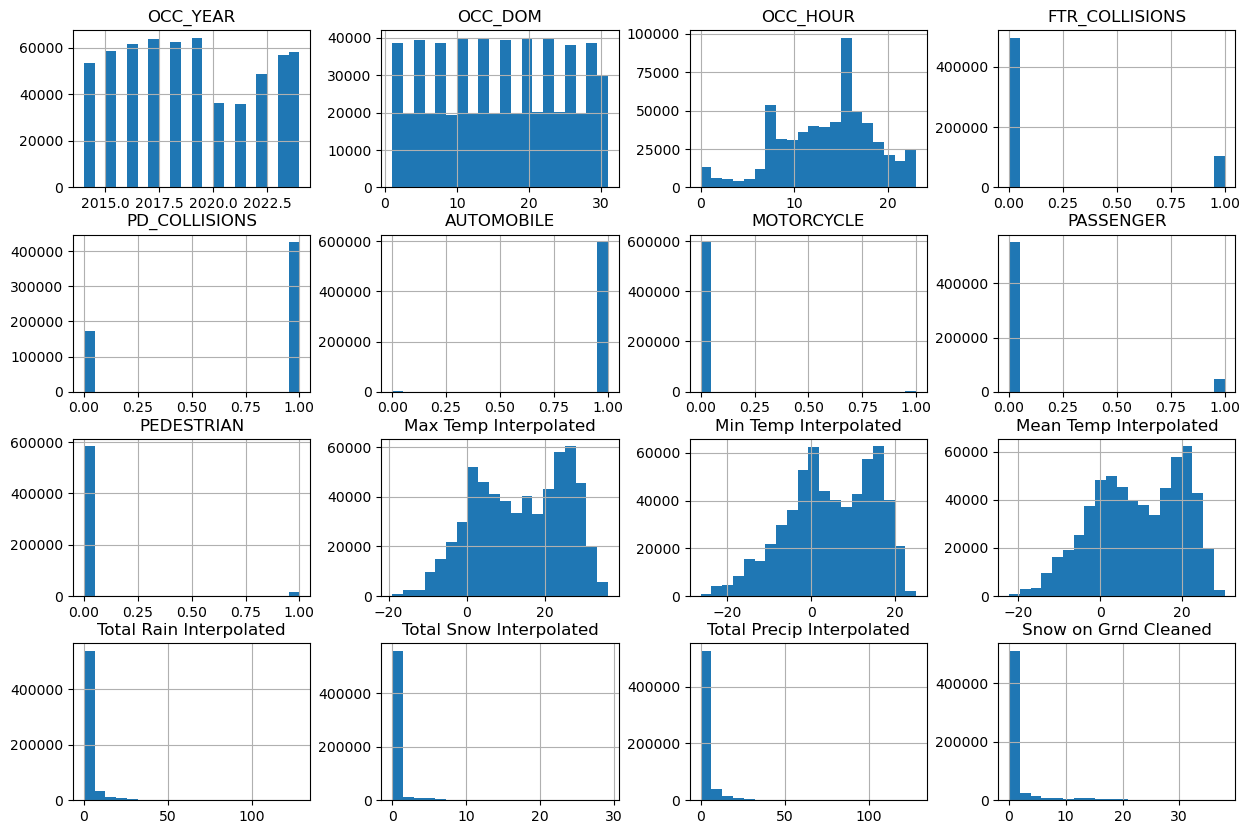

In [42]:
X.hist(figsize=(15,10), bins=20)

From the histogram above:
- max temp, min temp and mean temp can be scaled with standardization.
- total rain, snow and precip of the day, as well as snow on grnd can be replaced by it's log +1
- one hot encoding for year month and day of the week
- target encoding for hour, date of month and neighbourhood

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, TargetEncoder
import math

num_attribs_standardize = ["Max Temp Interpolated", "Min Temp Interpolated", "Mean Temp Interpolated"]
num_attribs_log = [ "Total Rain Interpolated", "Total Snow Interpolated", 
                "Total Precip Interpolated", "Snow on Grnd Cleaned"]
cat_attribs_one_hot = ["OCC_YEAR", "OCC_MONTH", "OCC_DOW"] 
cat_attribs_target = ["OCC_DOM", "OCC_HOUR", "NEIGHBOURHOOD_158"]
bin_attribs = ["AUTOMOBILE", "MOTORCYCLE", "PASSENGER", "PEDESTRIAN", "FTR_COLLISIONS", "PD_COLLISIONS"]

def log_plus_one(x):
    return math.log(1 + x)

# Standardize transformer
num_standardize_pipeline = make_pipeline(StandardScaler())
# Log transformer
num_log_pipeline = make_pipeline(FunctionTransformer(log_plus_one))
# One hot encoding
one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
# Target encoding
target_pipeline = make_pipeline(TargetEncoder(smooth = 10))

preprocessing = ColumnTransformer([
    ("num_standarize", num_standardize_pipeline, num_attribs_standardize),
    ("num_log", num_log_pipeline, num_attribs_log),
    ("one_hot", one_hot_pipeline, cat_attribs_one_hot),
    ("target_encode", target_pipeline, cat_attribs_target)
])

